# Load Data

In [4]:
import torch
import pandas as pd
import scanpy as sc
import numpy as np
import scipy.stats
from pathlib import Path
import umap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from scipy.stats import spearmanr
from statsmodels.stats.multitest import multipletests
import matplotlib.patches as patches
from sklearn.metrics import (
    silhouette_score,
    calinski_harabasz_score,
    davies_bouldin_score,
    adjusted_rand_score,
    normalized_mutual_info_score,
    adjusted_mutual_info_score,
    homogeneity_completeness_v_measure,
    fowlkes_mallows_score)
from matplotlib.lines import Line2D

## Load embeddings and aligned data

In [5]:
embeddings = torch.load("SHINE embeddings.pt")
emb_combined = embeddings['emb_combined']
emb_recon_transcript = embeddings['emb_recon_transcript']
emb_recon_metabolite = embeddings['emb_recon_metabolite']
emb_latent_transcript = embeddings['emb_latent_transcript']
emb_latent_metabolite = embeddings['emb_latent_metabolite']

In [6]:
transcript_info = pd.read_csv("aligned_ST_data.csv")
transcript_expr = transcript_info.iloc[:, 3:]
print(transcript_expr)
genes = transcript_expr.columns
genes

          HES4     ISG15      AGRN  B3GALT6      DVL1   MMP23B      NADK  \
0     0.000000  0.000000  0.000000      0.0  0.000000  0.00000  0.000000   
1     0.000000  0.000000  0.000000      0.0  0.000000  0.00000  0.000000   
2     0.000000  0.000000  0.000000      0.0  0.000000  0.00000  0.000000   
3     2.034278  0.000000  0.000000      0.0  0.000000  0.00000  2.034278   
4     0.000000  0.000000  0.000000      0.0  0.000000  2.00453  0.000000   
...        ...       ...       ...      ...       ...      ...       ...   
3503  0.000000  0.000000  0.000000      0.0  0.000000  0.00000  0.000000   
3504  0.000000  0.000000  1.475116      0.0  0.000000  0.00000  0.000000   
3505  0.000000  0.000000  0.000000      0.0  0.000000  0.00000  1.509310   
3506  0.000000  0.000000  0.000000      0.0  1.656833  0.00000  0.000000   
3507  0.000000  1.541677  0.000000      0.0  1.541677  0.00000  0.000000   

      PRKCZ  RNF207  PLEKHG5  ...  ZNF280C  SMIM10  FGF13  ZNF185    ZNF275  \
0       

Index(['HES4', 'ISG15', 'AGRN', 'B3GALT6', 'DVL1', 'MMP23B', 'NADK', 'PRKCZ',
       'RNF207', 'PLEKHG5',
       ...
       'ZNF280C', 'SMIM10', 'FGF13', 'ZNF185', 'ZNF275', 'PDZD4', 'SPRY3',
       'MT-CO3', 'MT-ND3', 'MT-ND5'],
      dtype='object', length=2000)

In [7]:
metabolite_info = pd.read_csv("aligned_SM_data.csv")
metabolite_abundance = metabolite_info.iloc[:, 3:]
print(metabolite_abundance)
metabolites = metabolite_abundance.columns
metabolites

      mz_255.23109612934098  mz_283.262461778844  mz_325.1826419711799  \
0                  6.143091             5.632000              4.953583   
1                  5.932466             5.350856              4.690055   
2                  5.887890             5.477233              4.926498   
3                  5.795459             5.211006              4.511011   
4                  6.634422             6.110658              5.253930   
...                     ...                  ...                   ...   
3503               6.023648             5.416932              4.684937   
3504               6.036555             5.556510              4.785568   
3505               5.820672             5.322518              4.949632   
3506               5.668235             5.174488              4.508577   
3507               5.774511             5.239114              4.582191   

      mz_311.1676841080394  mz_248.95872827128738  mz_339.1990497575424  \
0                 4.861265          

Index(['mz_255.23109612934098', 'mz_283.262461778844', 'mz_325.1826419711799',
       'mz_311.1676841080394', 'mz_248.95872827128738', 'mz_339.1990497575424',
       'mz_256.23444299891406', 'mz_112.98492851903', 'mz_297.15127632167696',
       'mz_284.2658086484171',
       ...
       'mz_272.22999598320604', 'mz_269.0140662769733', 'mz_477.2302905617134',
       'mz_947.5244869793153', 'mz_692.9527673663663', 'mz_362.1397349748619',
       'mz_697.4779777419988', 'mz_338.9279141150422', 'mz_846.6562282763398',
       'mz_275.82290572713964'],
      dtype='object', length=2082)

In [8]:
# Load original Visium AnnData
adata = sc.read_h5ad("BC_515_Section_1.h5ad")
adata.var_names_make_unique()

# Load matched transcript and metabolite info
transcript_info = pd.read_csv("aligned_ST_data.csv", index_col='spot')

barcodes_filtered = transcript_info.index.intersection(adata.obs_names)
adata_filtered = adata[barcodes_filtered, :].copy()

transcript_info = transcript_info.loc[barcodes_filtered, :]
adata_filtered = adata_filtered[transcript_info.index, :]

adata_filtered.obsm['spatial'] = adata_filtered.obsm['spatial']
adata_filtered

AnnData object with n_obs × n_vars = 3508 × 15953
    obs: 'orig.ident', 'nCount_Spatial', 'nFeature_Spatial', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.8', 'seurat_clusters', 'annotation'
    uns: 'msi', 'mz_features', 'orig.ident_colors', 'seurat_clusters_colors', 'spatial'
    obsm: 'X_harmony', 'X_pca', 'X_umap', 'spatial'
    layers: 'log1p', 'raw'

In [9]:
assert emb_combined.shape[0] == adata_filtered.n_obs, "Mismatch in combined embedding rows!"

for factor_idx in range(emb_combined.shape[1]):
    adata_filtered.obs[f'latent_combined_{factor_idx+1}'] = emb_combined[:, factor_idx]

print(adata_filtered.obs.iloc[:, -10:].head())
adata_filtered

                      latent_combined_247  latent_combined_248  \
AACACTTGGCAAGGAA-1_1                  0.0             0.004851   
AACAGGATTCATAGTT-1_1                  0.0             0.004993   
AACAGGTTATTGCACC-1_1                  0.0             0.004810   
AACAGGTTCACCGAAG-1_1                  0.0             0.005233   
AACAGTCAGGCTCCGC-1_1                  0.0             0.004786   

                      latent_combined_249  latent_combined_250  \
AACACTTGGCAAGGAA-1_1             0.061717             0.037999   
AACAGGATTCATAGTT-1_1             0.061907             0.038154   
AACAGGTTATTGCACC-1_1             0.061696             0.038497   
AACAGGTTCACCGAAG-1_1             0.062040             0.038326   
AACAGTCAGGCTCCGC-1_1             0.061594             0.037934   

                      latent_combined_251  latent_combined_252  \
AACACTTGGCAAGGAA-1_1             0.012814                  0.0   
AACAGGATTCATAGTT-1_1             0.012975                  0.0   
AACAGGTT

AnnData object with n_obs × n_vars = 3508 × 15953
    obs: 'orig.ident', 'nCount_Spatial', 'nFeature_Spatial', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.8', 'seurat_clusters', 'annotation', 'latent_combined_1', 'latent_combined_2', 'latent_combined_3', 'latent_combined_4', 'latent_combined_5', 'latent_combined_6', 'latent_combined_7', 'latent_combined_8', 'latent_combined_9', 'latent_combined_10', 'latent_combined_11', 'latent_combined_12', 'latent_combined_13', 'latent_combined_14', 'latent_combined_15', 'latent_combined_16', 'latent_combined_17', 'latent_combined_18', 'latent_combined_19', 'latent_combined_20', 'latent_combined_21', 'latent_combined_22', 'latent_combined_23', 'latent_combined_24', 'latent_combined_25', 'latent_combined_26', 'latent_combined_27', 'latent_combined_28', 'latent_combined_29', 'latent_combined_30', 'latent_combined_31', 'latent_combined_32', 'latent_combined_33', 'latent_combined_34', 'latent_combined_35', 'latent_combined_36', 'latent_combined_37', 'l

In [10]:
for factor_idx in range(emb_combined.shape[1]):
    adata_filtered.obs[f'latent_combined_{factor_idx}'] = emb_combined[:, factor_idx]

adata_filtered.obs.head()


,orig.ident,nCount_Spatial,nFeature_Spatial,nCount_SCT,nFeature_SCT,SCT_snn_res.0.8,seurat_clusters,annotation,latent_combined_1,latent_combined_2,...,latent_combined_248,latent_combined_249,latent_combined_250,latent_combined_251,latent_combined_252,latent_combined_253,latent_combined_254,latent_combined_255,latent_combined_256,latent_combined_0
AACACTTGGCAAGGAA-1_1,BC_515,437,350,1195,423,1,1,Stroma,0.038581,0.055101,...,0.061717,0.037999,0.012814,0.0,0.073112,0.090037,0.032611,0.070287,0.070287,0.069840
AACAGGATTCATAGTT-1_1,BC_515,1305,977,1583,965,0,0,Stroma,0.038975,0.055043,...,0.061907,0.038154,0.012975,0.0,0.073477,0.089196,0.033184,0.070783,0.070783,0.069528
AACAGGTTATTGCACC-1_1,BC_515,2594,1508,2424,1489,5,5,Stroma,0.038930,0.054854,...,0.061696,0.038497,0.012681,0.0,0.072848,0.088754,0.032920,0.070218,0.070218,0.069473
AACAGGTTCACCGAAG-1_1,BC_515,4743,2642,3009,2290,16,16,Stroma,0.039157,0.055313,...,0.062040,0.038326,0.012750,0.0,0.073095,0.088703,0.032904,0.070735,0.070735,0.069724
AACAGTCAGGCTCCGC-1_1,BC_515,1254,891,1557,884,1,1,Stroma,0.038731,0.055299,...,0.061594,0.037934,0.012669,0.0,0.073128,0.089343,0.032889,0.070365,0.070365,0.069601


## Annotation

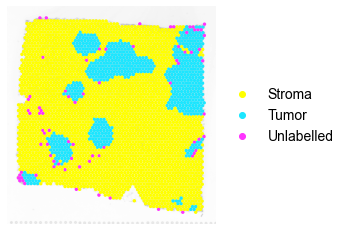

In [11]:
import scanpy as sc
import matplotlib.pyplot as plt
from matplotlib import rcParams
import numpy as np
import pandas as pd
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

# ---------------------------------------------------------
# Global font settings
# ---------------------------------------------------------
rcParams["font.family"] = "Arial"
rcParams["font.size"] = 16
rcParams["axes.titlesize"] = 16
rcParams["axes.labelsize"] = 14
rcParams["legend.fontsize"] = 14

library_id='BC_515'

# ---------------------------------------------------------
# Spatial visualization (annotation)
# ---------------------------------------------------------
cats = adata.obs["annotation"].astype("category").cat.categories.tolist()
base_palette = sc.pl.palettes.default_102
palette = dict(zip(cats, base_palette[:len(cats)]))

axs = sc.pl.spatial(
    adata,
    library_id=library_id,
    img_key="hires",
    color="annotation",     # visualize annotations
    size=1.5,
    palette=palette,
    alpha_img=0.6,
    bw=True,
    show=False,
    title=""
)

# Hide axes
if isinstance(axs, (list, tuple)):
    for ax in axs:
        ax.axis("off")
else:
    axs.axis("off")

# ---------------------------------------------------------
# Save figure
# ---------------------------------------------------------
plt.savefig(
    f"{library_id}_annotation_spatial.svg",
    format="svg",
    bbox_inches="tight",
    transparent=True,
    pad_inches=0
)
plt.show()


# Clustering

## ST latent embedding

/Users/dubingxue/opt/anaconda3/envs/transcript/lib/python3.8/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


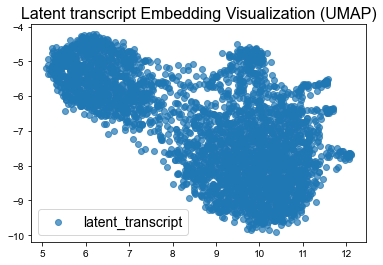

In [12]:
umap_reducer = umap.UMAP(n_components=2, random_state=42)
reduced_latent_transcript_umap = umap_reducer.fit_transform(emb_latent_transcript)

plt.scatter(reduced_latent_transcript_umap[:, 0], reduced_latent_transcript_umap[:, 1], label="latent_transcript", alpha=0.7)
plt.legend()
plt.title("Latent transcript Embedding Visualization (UMAP)")
plt.show()

adata = adata_filtered
adata.obsm['umap_latent_transcript'] = reduced_latent_transcript_umap

/Users/dubingxue/opt/anaconda3/envs/transcript/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


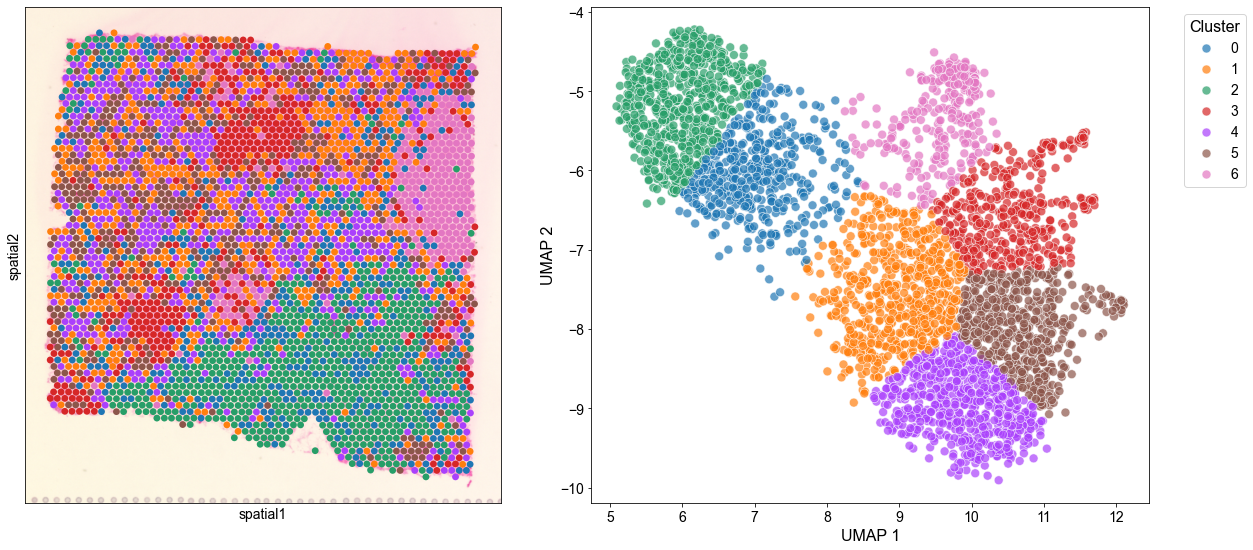

In [13]:
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 18

n_clusters =7

X = adata.obsm['umap_latent_transcript']
kmeans = KMeans(n_clusters=n_clusters, random_state=42)

clusters = kmeans.fit_predict(X)
adata.obs['umap_based_clusters'] = clusters.astype(str)

cats = [str(i) for i in range(n_clusters)]
adata.obs['umap_based_clusters'] = adata.obs['umap_based_clusters'].astype('category')
adata.obs['umap_based_clusters'] = adata.obs['umap_based_clusters'].cat.set_categories(cats, ordered=True)

base_palette = sc.pl.palettes.default_20[:n_clusters]
palette_dict = {c: base_palette[i] for i, c in enumerate(cats)}

fig, axes = plt.subplots(1, 2, figsize=(18, 8))

sc.pl.spatial(
    adata,
    color='umap_based_clusters',
    library_id='BC_515',   
    img_key='hires',
    spot_size=20.0,
    palette=[palette_dict[c] for c in cats],  
    legend_loc=None,
    title='',
    ax=axes[0],            
    show=False
)

sns.scatterplot(
    x=X[:, 0], y=X[:, 1],
    hue=adata.obs['umap_based_clusters'],
    palette=palette_dict,
    s=80, alpha=0.7,
    ax=axes[1],
    hue_order=cats,        
    legend='full'
)

axes[1].set_xlabel('UMAP 1', fontsize=16)
axes[1].set_ylabel('UMAP 2', fontsize=16)
axes[0].title.set_fontsize(16)
axes[1].title.set_fontsize(16)

for ax in axes:
    ax.tick_params(axis='both', which='major', labelsize=14)

leg = axes[1].legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.setp(leg.get_texts(), fontsize=14)
plt.setp(leg.get_title(), fontsize=16)

plt.tight_layout()
plt.savefig('SHINE-ST.svg', format='svg', bbox_inches='tight')
plt.show()

In [14]:
# Embedding used for clustering evaluation
X = adata.obsm["umap_latent_transcript"]

# Cluster assignments
labels = adata.obs["umap_based_clusters"].astype(int)

# Silhouette score
sil_score = silhouette_score(X, labels)
print(f"Silhouette Score: {sil_score:.3f}")

# Calinski–Harabasz index
ch_score = calinski_harabasz_score(X, labels)
print(f"Calinski-Harabasz Index: {ch_score:.3f}")

# Davies–Bouldin index
db_score = davies_bouldin_score(X, labels)
print(f"Davies-Bouldin Index: {db_score:.3f}")


# ---------------------------------------------------------
# External clustering validity metrics (against cell types)
# ---------------------------------------------------------
# Choose the object for evaluation
# If clustering was performed on adata_filtered, set obj = adata_filtered
obj = adata

# If "Cell type" is not available, copy from "annotation"
if "Cell type" not in obj.obs.columns and "annotation" in obj.obs.columns:
    obj.obs["Cell type"] = obj.obs["annotation"].copy()

# Valid index mask (ensure consistency with filtered data if applicable)
valid_idx = (
    np.ones(obj.shape[0], dtype=bool)
    if 'valid_idx' not in locals()
    else valid_idx
)

# Select valid observations
m = (
    valid_idx
    & obj.obs["Cell type"].notna().values
    & obj.obs["umap_based_clusters"].notna().values
)

y_true = obj.obs.loc[m, "Cell type"].astype(str).str.strip().values
y_pred = obj.obs.loc[m, "umap_based_clusters"].astype(str).str.strip().values

# Compute external clustering metrics
ARI = adjusted_rand_score(y_true, y_pred)
NMI = normalized_mutual_info_score(y_true, y_pred)
AMI = adjusted_mutual_info_score(y_true, y_pred)
h, c, v = homogeneity_completeness_v_measure(y_true, y_pred)
FMI = fowlkes_mallows_score(y_true, y_pred)

print("=== Clustering metrics ===")
print(f"ARI: {ARI:.3f}")
print(f"NMI: {NMI:.3f}")
print(f"AMI: {AMI:.3f}")
print(f"Homogeneity: {h:.3f}")
print(f"Completeness: {c:.3f}")
print(f"V-measure: {v:.3f}")
print(f"FMI: {FMI:.3f}")

# ---------------------------------------------------------
# Confusion matrix (cell type vs cluster assignment)
# ---------------------------------------------------------
cm = pd.crosstab(
    pd.Series(y_true, name="Cell type"),
    pd.Series(y_pred, name="umap_based_clusters")
)

print("\nConfusion matrix (Cell type vs clusters):")
print(cm)

Silhouette Score: 0.372
Calinski-Harabasz Index: 5873.543
Davies-Bouldin Index: 0.889
=== Clustering metrics ===
ARI: 0.066
NMI: 0.126
AMI: 0.125
Homogeneity: 0.261
Completeness: 0.083
V-measure: 0.126
FMI: 0.374

Confusion matrix (Cell type vs clusters):
umap_based_clusters    0    1    2    3    4    5    6
Cell type                                             
Stroma               410  500  641  161  543  406   46
Tumor                 42   97    4  219   49   95  218
Unlabelled             7   11    7   17    7   22    6


## SM latent embedding

/Users/dubingxue/opt/anaconda3/envs/transcript/lib/python3.8/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


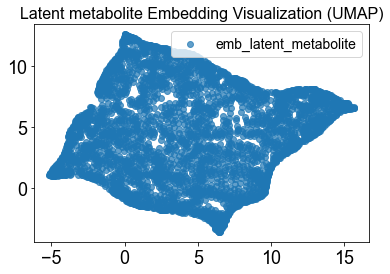

In [15]:
umap_reducer = umap.UMAP(n_components=2, random_state=42)
reduced_latent_metabolite_umap = umap_reducer.fit_transform(emb_latent_metabolite)

plt.scatter(reduced_latent_metabolite_umap[:, 0], reduced_latent_metabolite_umap[:, 1], label="emb_latent_metabolite", alpha=0.7)
plt.legend()
plt.title("Latent metabolite Embedding Visualization (UMAP)")
plt.show()

adata = adata_filtered
adata.obsm['umap_latent_metabolite'] = reduced_latent_metabolite_umap

/Users/dubingxue/opt/anaconda3/envs/transcript/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


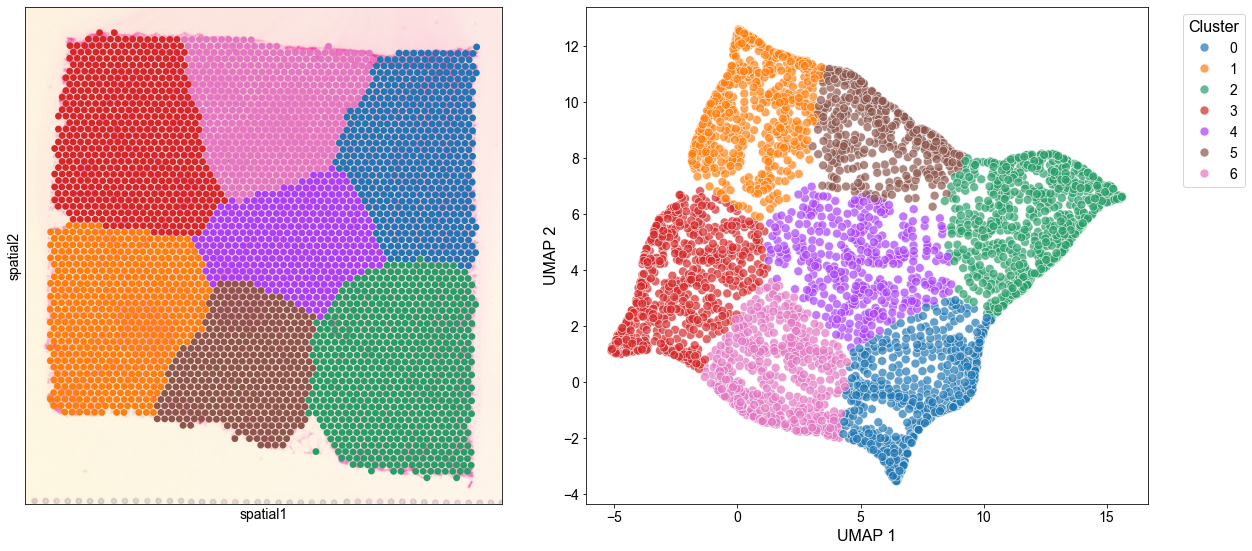

In [16]:
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 18

n_clusters =7

X = adata.obsm['umap_latent_metabolite']

kmeans = KMeans(n_clusters=n_clusters, random_state=42)

clusters = kmeans.fit_predict(X)
adata.obs['umap_based_clusters'] = clusters.astype(str)

cats = [str(i) for i in range(n_clusters)]
adata.obs['umap_based_clusters'] = adata.obs['umap_based_clusters'].astype('category')
adata.obs['umap_based_clusters'] = adata.obs['umap_based_clusters'].cat.set_categories(cats, ordered=True)

base_palette = sc.pl.palettes.default_20[:n_clusters]
palette_dict = {c: base_palette[i] for i, c in enumerate(cats)}

fig, axes = plt.subplots(1, 2, figsize=(18, 8))

sc.pl.spatial(
    adata,
    color='umap_based_clusters',
    library_id='BC_515',   
    img_key='hires',
    spot_size=20.0,
    palette=[palette_dict[c] for c in cats],  
    legend_loc=None,
    title='',
    ax=axes[0],          
    show=False
)

sns.scatterplot(
    x=X[:, 0], y=X[:, 1],
    hue=adata.obs['umap_based_clusters'],
    palette=palette_dict,
    s=80, alpha=0.7,
    ax=axes[1],
    hue_order=cats,       
    legend='full'
)

axes[1].set_xlabel('UMAP 1', fontsize=16)
axes[1].set_ylabel('UMAP 2', fontsize=16)
axes[0].title.set_fontsize(16)
axes[1].title.set_fontsize(16)

for ax in axes:
    ax.tick_params(axis='both', which='major', labelsize=14)

leg = axes[1].legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.setp(leg.get_texts(), fontsize=14)
plt.setp(leg.get_title(), fontsize=16)

plt.tight_layout()
plt.savefig('SHINE-SM.svg', format='svg', bbox_inches='tight')
plt.show()


In [17]:
from sklearn.metrics import (
    silhouette_score,
    calinski_harabasz_score,
    davies_bouldin_score,
)

# Embedding used for clustering evaluation
X = adata.obsm["umap_latent_metabolite"]

# Cluster assignments
labels = adata.obs["umap_based_clusters"].astype(int)

# Silhouette score
sil_score = silhouette_score(X, labels)
print(f"Silhouette Score: {sil_score:.3f}")

# Calinski–Harabasz index
ch_score = calinski_harabasz_score(X, labels)
print(f"Calinski-Harabasz Index: {ch_score:.3f}")

# Davies–Bouldin index
db_score = davies_bouldin_score(X, labels)
print(f"Davies-Bouldin Index: {db_score:.3f}")

# ---------------------------------------------------------
# External clustering validity metrics (against cell types)
# ---------------------------------------------------------
# Choose the object for evaluation
# If clustering was performed on adata_filtered, set obj = adata_filtered
obj = adata

# If "Cell type" is not available, copy from "annotation"
if "Cell type" not in obj.obs.columns and "annotation" in obj.obs.columns:
    obj.obs["Cell type"] = obj.obs["annotation"].copy()

# Valid index mask (ensure consistency with filtered data if applicable)
valid_idx = (
    np.ones(obj.shape[0], dtype=bool)
    if 'valid_idx' not in locals()
    else valid_idx
)

# Select valid observations
m = (
    valid_idx
    & obj.obs["Cell type"].notna().values
    & obj.obs["umap_based_clusters"].notna().values
)

y_true = obj.obs.loc[m, "Cell type"].astype(str).str.strip().values
y_pred = obj.obs.loc[m, "umap_based_clusters"].astype(str).str.strip().values

# Compute external clustering metrics
ARI = adjusted_rand_score(y_true, y_pred)
NMI = normalized_mutual_info_score(y_true, y_pred)
AMI = adjusted_mutual_info_score(y_true, y_pred)
h, c, v = homogeneity_completeness_v_measure(y_true, y_pred)
FMI = fowlkes_mallows_score(y_true, y_pred)

print("=== Clustering metrics ===")
print(f"ARI: {ARI:.3f}")
print(f"NMI: {NMI:.3f}")
print(f"AMI: {AMI:.3f}")
print(f"Homogeneity: {h:.3f}")
print(f"Completeness: {c:.3f}")
print(f"V-measure: {v:.3f}")
print(f"FMI: {FMI:.3f}")

# ---------------------------------------------------------
# Confusion matrix (cell type vs cluster assignment)
# ---------------------------------------------------------
cm = pd.crosstab(
    pd.Series(y_true, name="Cell type"),
    pd.Series(y_pred, name="umap_based_clusters")
)

print("\nConfusion matrix (Cell type vs clusters):")
print(cm)

Silhouette Score: 0.432
Calinski-Harabasz Index: 4328.282
Davies-Bouldin Index: 0.762
=== Clustering metrics ===
ARI: 0.045
NMI: 0.101
AMI: 0.100
Homogeneity: 0.210
Completeness: 0.066
V-measure: 0.101
FMI: 0.351

Confusion matrix (Cell type vs clusters):
umap_based_clusters    0    1    2    3    4    5    6
Cell type                                             
Stroma               198  436  618  524  353  336  242
Tumor                297   78   27   43   15   48  216
Unlabelled            19   27    8    9    0    8    6


## SHINE latent embedding

/Users/dubingxue/opt/anaconda3/envs/transcript/lib/python3.8/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


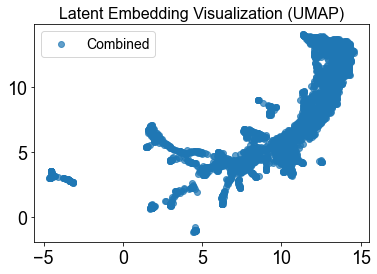

In [18]:
umap_reducer = umap.UMAP(n_components=2, random_state=42)
reduced_combined_umap = umap_reducer.fit_transform(emb_combined)

plt.scatter(reduced_combined_umap[:, 0], reduced_combined_umap[:, 1], label="Combined", alpha=0.7)
plt.legend()
plt.title("Latent Embedding Visualization (UMAP)")
plt.show()

adata = adata_filtered
adata.obsm['umap_combined'] = reduced_combined_umap

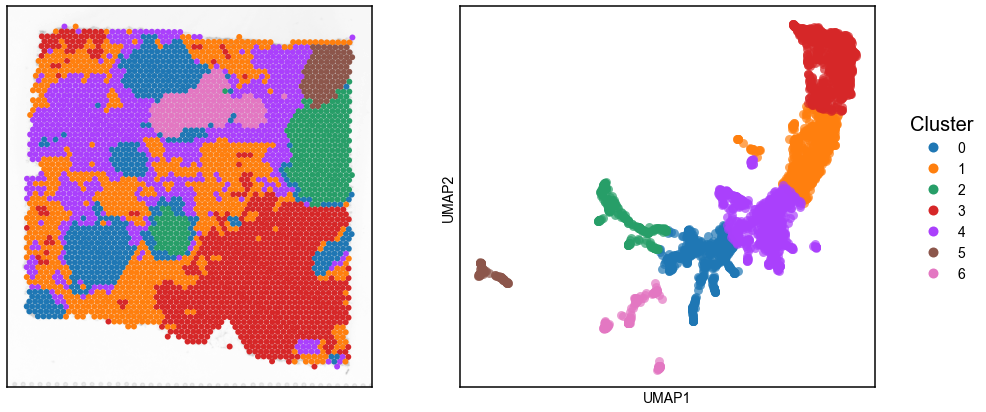

In [19]:
# -----------------------------
# 1) Global plotting style
# -----------------------------
plt.rcParams['font.family'] = 'Arial'
plt.rcParams['font.size'] = 20
plt.rcParams['axes.titlesize'] = 20

# -----------------------------
# 2) KMeans clustering on UMAP embedding
# -----------------------------
n_clusters = 7
X = adata.obsm['umap_combined']

kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X)
adata.obs['umap_based_clusters'] = clusters.astype(str)

# Recommended: fix category order to ensure stable color mapping
cats = sorted(
    adata.obs['umap_based_clusters'].unique(),
    key=lambda x: int(x) if x.isdigit() else x
)

# -----------------------------
# 3) Color mapping: cluster -> color
# -----------------------------
palette = sc.pl.palettes.default_20[:n_clusters]
palette_dict = {c: palette[i] for i, c in enumerate(cats)}

# -----------------------------
# 4) Canvas: 1 row × 2 columns (left: Spatial, right: UMAP)
# -----------------------------
fig, axes = plt.subplots(
    1, 2,
    figsize=(16, 7),
    gridspec_kw={"wspace": 0.15}
)

# ===== Left panel: Spatial (disable built-in legend to avoid duplication) =====
sc.pl.spatial(
    adata,
    color='umap_based_clusters',
    library_id='BC_515',
    img_key='hires',
    palette=[palette_dict[c] for c in cats],  # enforce mapping order
    size=1.5,
    bw=True,
    alpha_img=0.6,
    ax=axes[0],
    show=False,
    legend_loc=None,
    title=""
)

axes[0].set_xticks([])
axes[0].set_yticks([])
axes[0].set_xlabel('')
axes[0].set_ylabel('')

for spine in axes[0].spines.values():
    spine.set_visible(True)
    spine.set_linewidth(1.5)
    spine.set_color('black')

# ===== Right panel: UMAP (colors consistent with Spatial) =====
for c in cats:
    mask = (adata.obs['umap_based_clusters'].values == c)
    axes[1].scatter(
        X[mask, 0],
        X[mask, 1],
        s=80,
        alpha=0.7,
        c=[palette_dict[c]],
        linewidths=0
    )

axes[1].set_xlabel("UMAP1")
axes[1].set_ylabel("UMAP2")
axes[1].set_title("")

axes[1].set_xticks([])
axes[1].set_yticks([])

for spine in axes[1].spines.values():
    spine.set_visible(True)
    spine.set_linewidth(1.5)
    spine.set_color('black')

# -----------------------------
# 5) Global legend (single legend on the right)
# -----------------------------
handles = [
    Line2D(
        [0], [0],
        marker='o',
        linestyle='',
        markersize=10,
        markerfacecolor=palette_dict[c],
        markeredgecolor='none',
        label=c
    )
    for c in cats
]

leg = fig.legend(
    handles=handles,
    title="Cluster",
    loc="center left",
    bbox_to_anchor=(0.92, 0.5),
    frameon=False
)
leg.get_title().set_fontsize('medium')

# -----------------------------
# 6) Save figure
# -----------------------------
plt.savefig('SHINE.svg', format='svg', bbox_inches='tight')
plt.show()


In [20]:
import numpy as np
import pandas as pd

# ---------------------------------------------------------
# Internal clustering validity metrics (unsupervised)
# ---------------------------------------------------------
# Low-dimensional embedding used for clustering
X = adata.obsm['umap_combined']

# Cluster labels
labels = adata.obs['umap_based_clusters'].astype(int)

# Silhouette score
sil_score = silhouette_score(X, labels)
print(f'Silhouette Score: {sil_score:.3f}')

# Calinski–Harabasz index
ch_score = calinski_harabasz_score(X, labels)
print(f'Calinski-Harabasz Index: {ch_score:.3f}')

# Davies–Bouldin index
db_score = davies_bouldin_score(X, labels)
print(f'Davies-Bouldin Index: {db_score:.3f}')

# ---------------------------------------------------------
# External clustering validity metrics (against cell types)
# ---------------------------------------------------------
# Choose the object for evaluation
# If clustering was performed on adata_filtered, set obj = adata_filtered
obj = adata

# If "Cell type" is not available, copy from "annotation"
if "Cell type" not in obj.obs.columns and "annotation" in obj.obs.columns:
    obj.obs["Cell type"] = obj.obs["annotation"].copy()

# Valid index mask (ensure consistency with filtered data if applicable)
valid_idx = (
    np.ones(obj.shape[0], dtype=bool)
    if 'valid_idx' not in locals()
    else valid_idx
)

# Select valid observations
m = (
    valid_idx
    & obj.obs["Cell type"].notna().values
    & obj.obs["umap_based_clusters"].notna().values
)

y_true = obj.obs.loc[m, "Cell type"].astype(str).str.strip().values
y_pred = obj.obs.loc[m, "umap_based_clusters"].astype(str).str.strip().values

# Compute external clustering metrics
ARI = adjusted_rand_score(y_true, y_pred)
NMI = normalized_mutual_info_score(y_true, y_pred)
AMI = adjusted_mutual_info_score(y_true, y_pred)
h, c, v = homogeneity_completeness_v_measure(y_true, y_pred)
FMI = fowlkes_mallows_score(y_true, y_pred)

print("=== Clustering metrics ===")
print(f"ARI: {ARI:.3f}")
print(f"NMI: {NMI:.3f}")
print(f"AMI: {AMI:.3f}")
print(f"Homogeneity: {h:.3f}")
print(f"Completeness: {c:.3f}")
print(f"V-measure: {v:.3f}")
print(f"FMI: {FMI:.3f}")

# ---------------------------------------------------------
# Confusion matrix (cell type vs cluster assignment)
# ---------------------------------------------------------
cm = pd.crosstab(
    pd.Series(y_true, name="Cell type"),
    pd.Series(y_pred, name="umap_based_clusters")
)

print("\nConfusion matrix (Cell type vs clusters):")
print(cm)

Silhouette Score: 0.516
Calinski-Harabasz Index: 8714.331
Davies-Bouldin Index: 0.587
=== Clustering metrics ===
ARI: 0.174
NMI: 0.294
AMI: 0.293
Homogeneity: 0.564
Completeness: 0.199
V-measure: 0.294
FMI: 0.498

Confusion matrix (Cell type vs clusters):
umap_based_clusters    0    1    2    3    4   5    6
Cell type                                            
Stroma               231  842   21  833  768   6    6
Tumor                220    4  242    0   32  73  153
Unlabelled            29   14    5    4   16   9    0


In [21]:

obj = adata  # <-- replace with the AnnData you want to evaluate (e.g., adata_int, adata_st, etc.)

# ================================
# Load the saved label file (pathology-guided single-cell annotations)
#   - "final_label" is treated as the ground-truth reference derived from pathology-guided single-cell labeling/mapping.
#   - The CSV is expected to contain:
#       spot: spot/barcode ID (should match AnnData.obs_names)
#       final_label: reference label per spot
# ================================
df_lab = pd.read_csv("spatial_final_labels.csv")  # columns: spot, final_label
df_lab = df_lab.set_index("spot")

# ================================
# Align by spot IDs (obs_names) between AnnData and the label table
# ================================
# Keep only spots present in BOTH AnnData and the label file
common = obj.obs_names.intersection(df_lab.index)

# Subset AnnData and labels to the common spots
obj_sub = obj[common].copy()
lab_sub = df_lab.loc[common]

# ================================
# Define y_true (reference) and y_pred (model clusters)
# ================================
# y_true: pathology-guided single-cell annotation label per spot (reference/ground truth)
y_true = lab_sub["final_label"].astype(str).str.strip().values

# y_pred: your predicted clusters (e.g., UMAP-based clustering result stored in AnnData.obs)
y_pred = obj_sub.obs["umap_based_clusters"].astype(str).str.strip().values

# ================================
# Compute clustering agreement metrics
# ================================
ARI = adjusted_rand_score(y_true, y_pred)
NMI = normalized_mutual_info_score(y_true, y_pred)
AMI = adjusted_mutual_info_score(y_true, y_pred)
h, c, v = homogeneity_completeness_v_measure(y_true, y_pred)
FMI = fowlkes_mallows_score(y_true, y_pred)

print("=== Clustering metrics (pathology-guided single-cell labels vs predicted clusters) ===")
print(f"ARI: {ARI:.3f}")
print(f"NMI: {NMI:.3f}")
print(f"AMI: {AMI:.3f}")
print(f"Homogeneity: {h:.3f}")
print(f"Completeness: {c:.3f}")
print(f"V-measure: {v:.3f}")
print(f"FMI: {FMI:.3f}")

# ================================
# Confusion matrix (contingency table)
#   Rows: pathology-guided single-cell labels (reference)
#   Cols: predicted clusters
# ================================
cm = pd.crosstab(
    pd.Series(y_true, name="final_label (pathology-guided single-cell annotation)"),
    pd.Series(y_pred, name="umap_based_clusters (predicted)")
)

print("\nConfusion matrix (reference labels vs predicted clusters):")
print(cm)


=== Clustering metrics (pathology-guided single-cell labels vs predicted clusters) ===
ARI: 0.162
NMI: 0.261
AMI: 0.258
Homogeneity: 0.248
Completeness: 0.275
V-measure: 0.261
FMI: 0.318

Confusion matrix (reference labels vs predicted clusters):
umap_based_clusters (predicted)                       0    1    2    3    4  \
final_label (pathology-guided single-cell annot...                            
CAFs                                                 28  119    0  320  229   
Cancer Basal/Her2 SC                                 46    0   78    0    1   
Cancer Cycling                                        1    0    0    0    0   
Cancer LumA/B SC                                     52    0  124    0    1   
Immune                                               84  262    3  304   77   
Normal epithelial                                    15   23    0   10   34   
Other (stroma region)                                87   58   18   53   41   
Other (tumor region)                      

# Comparison

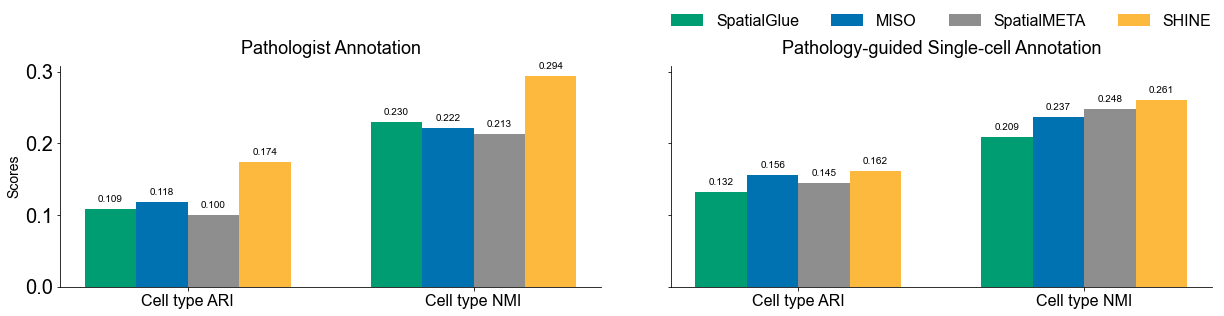

In [22]:
plt.rcParams['font.family'] = 'Arial'

indicators = ['Cell type ARI', 'Cell type NMI']
methods = ['SpatialGlue', 'MISO', 'SpatialMETA', 'SHINE']
colors = ['#009D73', '#0072b2', '#8E8E8E', '#fcb93e']

# =========================
# Data
# =========================
# Pathologist-based
data_coarse = np.array([
    [0.109, 0.230],  # SpatialGlue
    [0.118, 0.222],  # MISO
    [0.100, 0.213],  # SpatialMETA
    [0.174, 0.294],  # SHINE
])

# Pathology-guided single-cell
data_fine = np.array([
    [0.132, 0.209],  # SpatialGlue
    [0.156, 0.237],  # MISO
    [0.145, 0.248],  # SpatialMETA
    [0.162, 0.261],  # SHINE
])

# =========================
# Plot
# =========================
x = np.arange(len(indicators))
width = 0.18

fig, axes = plt.subplots(1, 2, figsize=(18, 5), sharey=True)

def plot_panel(ax, data, title, show_ylabel=False):
    rects = []
    for i, method in enumerate(methods):
        rect = ax.bar(
            x + (i - (len(methods) - 1) / 2) * width,
            data[i],
            width,
            label=method,
            color=colors[i]
        )
        rects.append(rect)

    ax.set_title(title, fontsize=18, pad=12)
    ax.set_xticks(x)
    ax.set_xticklabels(indicators, fontsize=16)

    if show_ylabel:
        ax.set_ylabel('Scores', fontsize=14)

    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)

    for rect_group in rects:
        for rect in rect_group:
            height = rect.get_height()
            ax.annotate(
                f'{height:.3f}',
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 5),
                textcoords="offset points",
                ha='center',
                va='bottom',
                fontsize=10
            )

# Left: c
plot_panel(
    axes[0],
    data_coarse,
    title='Pathologist Annotation',
    show_ylabel=True
)

# Right: d
plot_panel(
    axes[1],
    data_fine,
    title='Pathology-guided Single-cell Annotation'
,)

# =========================
# Legend (shared)
# =========================
axes[1].legend(
    fontsize=16,
    loc='upper center',
    bbox_to_anchor=(0.5, 1.3),
    ncol=4,
    frameon=False
)

fig.tight_layout()

# =========================
# Save
# =========================
plt.savefig(
    'metrics_comparison_pathologist_vs_pathology_guided.svg',
    format='svg',
    bbox_inches='tight'
)

plt.show()
